In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
% matplotlib inline

In [2]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [3]:
from sklearn.preprocessing import PolynomialFeatures

In [4]:
data = make_moons(n_samples=1000, noise=0.2)
X, y = data

In [5]:
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

In [6]:
X_poly[0]

array([ 1.        , -0.08451741, -0.20255925,  0.00714319,  0.01711978,
        0.04103025])

In [7]:
# reshape y to be a column vector
y_col = y.reshape(-1, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_col, test_size=0.2)

In [9]:
def random_batch(X_train, y_train, batch_size):
    batch_indices = np.random.randint(0, len(X_train), size=batch_size)
    X_batch = X_train[batch_indices]
    y_batch = y_train[batch_indices]
    return X_batch, y_batch

In [10]:
def logistic_regression(X, y, seed=69, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)    
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver
    

In [11]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}".format(root_logdir, name)

In [12]:
m, n_inputs = X_train.shape
logdir = log_dir("logreg")

In [13]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

In [14]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

In [15]:
y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [16]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "./my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)
            

Epoch 0 	Loss: 0.61555
Epoch 500 	Loss: 0.264782
Epoch 1000 	Loss: 0.25931
Epoch 1500 	Loss: 0.25574
Epoch 2000 	Loss: 0.254329
Epoch 2500 	Loss: 0.254058
Epoch 3000 	Loss: 0.253164
Epoch 3500 	Loss: 0.253062
Epoch 4000 	Loss: 0.252715
Epoch 4500 	Loss: 0.2521
Epoch 5000 	Loss: 0.253114
Epoch 5500 	Loss: 0.252005
Epoch 6000 	Loss: 0.252088
Epoch 6500 	Loss: 0.251754
Epoch 7000 	Loss: 0.252467
Epoch 7500 	Loss: 0.252998
Epoch 8000 	Loss: 0.253168
Epoch 8500 	Loss: 0.253225
Epoch 9000 	Loss: 0.252818
Epoch 9500 	Loss: 0.253507
Epoch 10000 	Loss: 0.253185


In [17]:
y_pred = (y_proba_val >= 0.5)

In [18]:
def scores(y_test, y_pred):
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))
    print("Precision Score: {}".format(precision_score(y_test, y_pred)))
    print("Recall Score: {}".format(recall_score(y_test, y_pred)))

In [19]:
scores(y_test, y_pred)

Accuracy Score: 0.88
Precision Score: 0.8842105263157894
Recall Score: 0.865979381443299


In [20]:
y_pred_idx = y_pred.reshape(-1)
y_pred_idx
y_test_idx = y_test.reshape(-1)

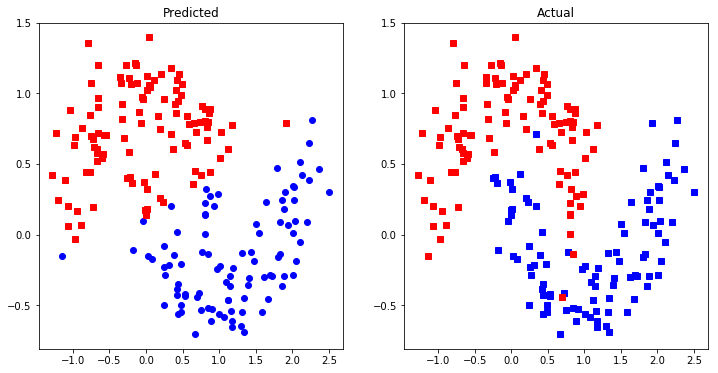

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], "bo")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], "rs")
plt.title("Predicted")

plt.subplot(1, 2, 2)
plt.plot(X_test[:, 1][y_test_idx == 1], X_test[:, 2][y_test_idx == 1], 'bs')
plt.plot(X_test[:, 1][y_test_idx == 0], X_test[:, 2][y_test_idx == 0], 'rs')
plt.title("Actual")